In [1]:
from matplotlib import pyplot as plt

# import libraries for dataframes, tensors and arrays
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import os
import datetime
from darts import TimeSeries

In [2]:
# Read in the new data file
df = pd.read_csv('household_with_pv.csv', parse_dates=["Dates"])
df = df.fillna(0).set_index("Dates")

means, std = df.mean(), df.std()

normalized = (df - means)/std

dt_index = df.index
new_end_date = dt_index[-1] + pd.DateOffset(months=1)

# Create a new DatetimeIndex starting from the first date of the original index to the new end date, hourly
extended_dt_index = pd.date_range(start=dt_index[0], end=new_end_date, freq='H')

covs = [
    np.sin(2 * np.pi * extended_dt_index.hour / 24),
    np.cos(2 * np.pi * extended_dt_index.hour / 24),
    (extended_dt_index.weekday > 4).astype(float),
    # np.sin(2 * np.pi * extended_dt_index.month / 12),
    # np.cos(2 * np.pi * extended_dt_index.month / 12),
]    
covs = pd.DataFrame(covs).T
covs.index = extended_dt_index
assert covs.isna().any().any() == False
assert normalized.isna().any().any() == False
covs.reset_index()

,index,0,1,2
0,2021-06-01 00:00:00,0.000000,1.000000,0.0
1,2021-06-01 01:00:00,0.258819,0.965926,0.0
2,2021-06-01 02:00:00,0.500000,0.866025,0.0
3,2021-06-01 03:00:00,0.707107,0.707107,0.0
4,2021-06-01 04:00:00,0.866025,0.500000,0.0
...,...,...,...,...
9475,2022-06-30 19:00:00,-0.965926,0.258819,0.0
9476,2022-06-30 20:00:00,-0.866025,0.500000,0.0
9477,2022-06-30 21:00:00,-0.707107,0.707107,0.0
9478,2022-06-30 22:00:00,-0.500000,0.866025,0.0


In [3]:
covs = TimeSeries.from_dataframe(covs.reset_index(), "index")
series = TimeSeries.from_dataframe(normalized.reset_index(), "Dates")

train, val = series.split_before(0.8)

<Axes: xlabel='Dates'>

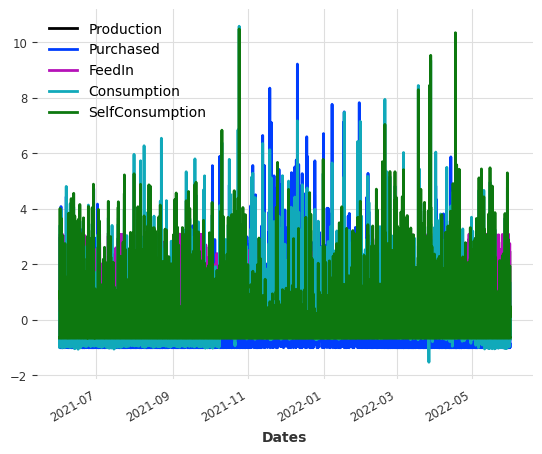

In [4]:
series.plot()

In [5]:
# from darts.models import RegressionModel
# from sklearn.linear_model import BayesianRidge

# model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

# model.fit(
#     [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
# );

(0.8780965030878546, 0.4579562071826918)

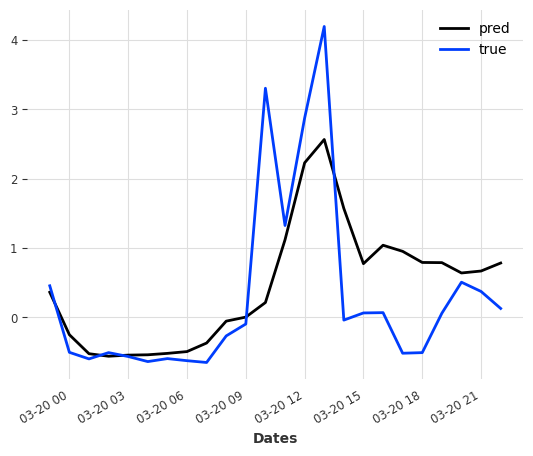

In [7]:
from darts.models.forecasting.xgboost import XGBModel
from darts.metrics import r2_score, rmse

params = {
    "learning_rate": 0.07014188001597053,
    "max_depth": 4,
    "gamma": 1.0518764146499875,
    "reg_alpha": 0.0070217178903161925,
    "reg_lambda": 0.2538094460672119,
    "colsample_bytree": 0.6221196927178515,
    "min_child_weight": 10,
    "n_estimators": 294,
}


model = XGBModel(lags=60, lags_future_covariates=(20, 5), **params, random_state= 0)

model.fit(train[["Consumption"]], future_covariates=[covs])

preds = model.predict(len(val), train[["Consumption"]], future_covariates=[covs])
# preds.plot()

preds["Consumption"][: 24].plot(label="pred")
val["Consumption"][: 24].plot(label="true")

rmse_val, r2_val = rmse(val["Consumption"], preds), r2_score(val["Consumption"][: 24], preds[: 24])
rmse_val, r2_val

<Axes: xlabel='Dates'>

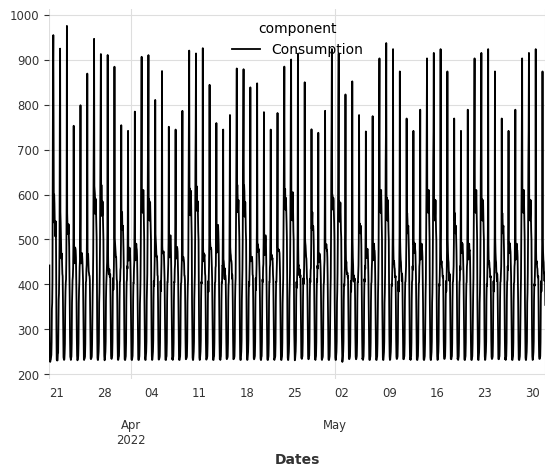

In [8]:
preds_df = (preds.pd_dataframe() * std["Consumption"] )+ means["Consumption"]
df.loc[preds_df.index, "Pred"] = preds_df.Consumption
preds_df.plot()

In [9]:
from sklearn.metrics import r2_score

In [10]:
resampled = df[["Pred","Consumption"]].dropna()
res = resampled.resample('W-MON').apply(lambda x: r2_score(x["Consumption"], x["Pred"]) if not x.empty else None)
res.idxmax()

Timestamp('2022-03-21 00:00:00')

In [11]:
start_date = res.idxmax()
end_date = start_date + pd.Timedelta(days=6)

# Slicing the dataframe
week_df = df[:end_date]
df["data"] = "Normal"
df.loc[start_date:end_date,"data"] = "Last"

<Axes: xlabel='Dates'>

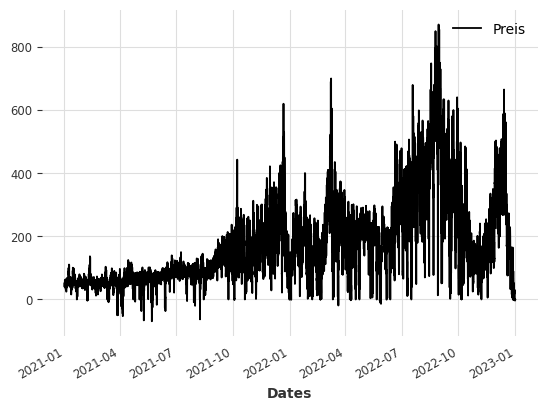

In [12]:
def get_price(path):
    
    df = pd.read_csv(path, skiprows=1)
    
    df = df.rename(columns={'Unnamed: 0':'Dates'})
    df.Dates = df.Dates.apply(lambda x: x[:13])
    df.Dates = pd.to_datetime(df.Dates, format = '%Y-%m-%dT%H')
    df.index = pd.DatetimeIndex(df.Dates)
    df = df.drop(columns=["Dates"])
    preis = df.iloc[:,-1]
    return preis


price = pd.concat([
    get_price("energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2021.csv"),
    get_price("energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2022.csv"),
])
price.name = "Preis"
price = price.to_frame()
price.plot()

In [20]:
better_price = np.maximum(price, 0) * 1.2 + 12.28

In [21]:
with_price = df.join(better_price)
with_price.to_csv("processed_data.csv")

In [18]:
price, df

(                     Preis
 Dates                     
 2021-01-01 00:00:00  50.87
 2021-01-01 01:00:00  48.19
 2021-01-01 02:00:00  44.68
 2021-01-01 03:00:00  42.92
 2021-01-01 04:00:00  40.39
 ...                    ...
 2022-12-31 19:00:00  -1.01
 2022-12-31 20:00:00  -1.39
 2022-12-31 21:00:00  -1.04
 2022-12-31 22:00:00  -1.07
 2022-12-31 23:00:00  -0.68
 
 [17520 rows x 1 columns],
                      Production  Purchased  FeedIn  Consumption  \
 Dates                                                             
 2021-06-01 00:00:00         0.0      222.0     0.0        222.0   
 2021-06-01 01:00:00         0.0      142.0     0.0        142.0   
 2021-06-01 02:00:00         0.0      148.0     0.0        148.0   
 2021-06-01 03:00:00         0.0      159.0     0.0        159.0   
 2021-06-01 04:00:00         0.0      123.0     0.0        123.0   
 ...                         ...        ...     ...          ...   
 2022-05-31 19:00:00       500.0       97.0   218.0        379.

In [19]:

df

,Production,Purchased,FeedIn,Consumption,SelfConsumption,Pred,data
Dates,,,,,,,
2021-06-01 00:00:00,0.0,222.0,0.0,222.0,0.0,NaN,Normal
2021-06-01 01:00:00,0.0,142.0,0.0,142.0,0.0,NaN,Normal
2021-06-01 02:00:00,0.0,148.0,0.0,148.0,0.0,NaN,Normal
2021-06-01 03:00:00,0.0,159.0,0.0,159.0,0.0,NaN,Normal
2021-06-01 04:00:00,0.0,123.0,0.0,123.0,0.0,NaN,Normal
...,...,...,...,...,...,...,...
2022-05-31 19:00:00,500.0,97.0,218.0,379.0,282.0,426.330566,Normal
2022-05-31 20:00:00,149.0,112.0,34.0,227.0,115.0,407.770782,Normal
2022-05-31 21:00:00,0.0,236.0,0.0,236.0,0.0,423.488586,Normal
